In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import gzip 
import tqdm
import requests


def harmonic_sum(data, scale_factor=1, cap=None):
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """
    
    if isinstance(data, pd.Series):
        data = data.tolist()
    
    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum


def add_missing_efo(efo_ids):
    missing_efo_map = {}
    for efo_id in efo_ids:
        url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={efo_id}'
        r = requests.get(url)
        data = r.json()

        missing_efo_map[efo_id] = data['_embedded']['terms'][0]['label']

    return missing_efo_map
        

def add_missing_genes(genes):
    missing_gene_map = {}
    for ensembl_id in genes:
        r = requests.get(f'http://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json;expand=0')
        missing_gene_map[ensembl_id] = r.json()['display_name']
        
    return missing_gene_map


def so_lookup(so_term):
    '''
    Function to do the OLS lookup, returns with the label.
    '''
    
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={so_term}'
    r = requests.get(url)
    data = r.json()

    return data['_embedded']['terms'][0]['label']
    

def read_eva_evidences(source_file):
    
    parsed_data = []

    with gzip.open(source_file) as f:
        for line in f:
            data = json.loads(line)
            evidence = {
                'type': data['type'],
                'target': data['unique_association_fields']['gene'],
                'disease': data['unique_association_fields']['phenotype'].split('/')[-1],
                'rsid': data['unique_association_fields']['variant_id'],
                'clinvar_acces': data['unique_association_fields']['clinvarAccession'],   
            }

            if data['type'] == 'genetic_association':
                evidence.update({
                    'score': data['evidence']['variant2disease']['resource_score']['value'],
                    'star': data['evidence']['variant2disease']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['variant2disease']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['variant2disease']['clinical_significance'],
                    'so_code':  data['evidence']['gene2variant']['functional_consequence'].split('/')[-1],
                })

            elif data['type'] == 'somatic_mutation':
                evidence.update({
                    'score': data['evidence']['resource_score']['value'],
                    'star': data['evidence']['clinvar_rating']['star_rating'],
                    'review_status': data['evidence']['clinvar_rating']['review_status'],
                    'clinical_significance': data['evidence']['clinical_significance'],
                    'so_code': data['evidence']['known_mutations'][0]['functional_consequence'].split('/')[-1],
                })
            parsed_data.append(evidence)

    return pd.DataFrame(parsed_data)




In [52]:
eva = pd.read_parquet('EVA_processed_2020.10.25.parquet')


eva_consequences_order_map = {
    'downstream_gene_variant': 0.6,
    'upstream_gene_variant': 0.6,
    'intron_variant': 0.65,
    'non_coding_transcript_exon_variant': 0.65,
    '3_prime_UTR_variant': 0.65,
    '5_prime_UTR_variant': 0.65,
    'mature_miRNA_variant': 0.65,
    'coding_sequence_variant': 0.95,
    'synonymous_variant': 0.65,
    'stop_retained_variant': 0.65,
    'incomplete_terminal_codon_variant': 0.9,
    'splice_region_variant': 0.9,
    'protein_altering_variant': 0.7,
    'missense_variant': 0.7,
    'inframe_deletion': 0.7,
    'inframe_insertion': 0.7,
    'start_lost': 0.95,
    'stop_lost': 0.9,
    'frameshift_variant': 0.95,
    'stop_gained': 0.95,
    'splice_donor_variant': 0.95,
    'splice_acceptor_variant': 0.95,
    'trinucleotide_repeat_expansion': 1,
    'short_tandem_repeat_expansion': 1,
    'transcript_ablation':1
}

# Review status is an ordinal variable. Mapping to numbers:
review_status_order_map = {
    'no assertion provided': 1/7,
    'no assertion criteria provided': 2/7,
    'criteria provided, conflicting interpretations': 3/7,
    'criteria provided, single submitter': 4/7,
    'criteria provided, multiple submitters, no conflicts': 5/7,
    'reviewed by expert panel': 6/7,
    'practice guideline': 7/7
}

clinical_significance_mapping = {
    'association not found': 0,  
    'benign': 0,
    'not provided': 0,
    'uncertain significance': 0.01,    
    'likely benign': 0.2,    
    'conflicting interpretations of pathogenicity': 0.5,   
    'other': 0.3,
    'association': 1,
    'drug response': 1,
    'protective':1,
    'affects': 0.7,
    'likely pathogenic' : 0.8,
    'risk factor': 0.8,
    'pathogenic' : 1,
}

# Subsetting eva dataframe:
simplified_evid = eva[['target','disease','consequence','poscon','review_status']].copy()

# Generate weights for consequence terms:
simplified_evid['consequence_weighted'] = simplified_evid.consequence.map(eva_consequences_order_map)

# Generate weights for review status:
simplified_evid['review_weighted'] = simplified_evid.review_status.map(review_status_order_map)

# Generate weight for clinical significance:
simplified_evid['clin_sig_weighted'] = eva.clinical_significance.apply(lambda x: np.max([clinical_significance_mapping[y] for y in x]))

simplified_evid.head()

,target,disease,consequence,poscon,review_status,consequence_weighted,review_weighted,clin_sig_weighted
0,ENSG00000154803,Orphanet_2903,frameshift_variant,False,no assertion criteria provided,0.95,0.285714,1.0
1,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0
2,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0
3,ENSG00000103197,Orphanet_805,inframe_deletion,False,no assertion provided,0.70,0.142857,0.0
4,ENSG00000129422,EFO_0002950,splice_acceptor_variant,False,no assertion provided,0.95,0.142857,0.0


In [36]:
##
## Sampling dataframe:
##

pos_sample_size = len(simplified_evid.loc[simplified_evid.poscon])
negative_upsampled = simplified_evid.loc[simplified_evid.poscon].sample(10*pos_sample_size, replace=True)
df = pd.concat([simplified_evid.loc[simplified_evid.poscon].copy(), negative_upsampled])
len(df)

459305

In [46]:
pos_sample_size

41755

In [53]:
# Build classifier:
rf = RandomForestClassifier(class_weight='balanced')
columns = ['consequence_weighted', 'review_weighted', 'clin_sig_weighted']
rf.fit(simplified_evid[columns],simplified_evid.poscon)  

# Extracting weight:
print('Extract weights...')
weight_series = pd.Series(rf.feature_importances_, index=columns)
print(weight_series)


Extract weights...
consequence_weighted    0.205899
review_weighted         0.391467
clin_sig_weighted       0.402634
dtype: float64


In [54]:
# Generate evidence score:
def calculate_evidence_score(row):
    score = 0
    for col in columns:
        score += row[col]*weight_series[col]
        
    return score

simplified_evid['evidence_score'] = simplified_evid.apply(calculate_evidence_score, axis=1)
simplified_evid.head()

,target,disease,consequence,poscon,review_status,consequence_weighted,review_weighted,clin_sig_weighted,evidence_score
0,ENSG00000154803,Orphanet_2903,frameshift_variant,False,no assertion criteria provided,0.95,0.285714,1.0,0.710086
1,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0,0.251528
2,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.0,0.251528
3,ENSG00000103197,Orphanet_805,inframe_deletion,False,no assertion provided,0.70,0.142857,0.0,0.200053
4,ENSG00000129422,EFO_0002950,splice_acceptor_variant,False,no assertion provided,0.95,0.142857,0.0,0.251528


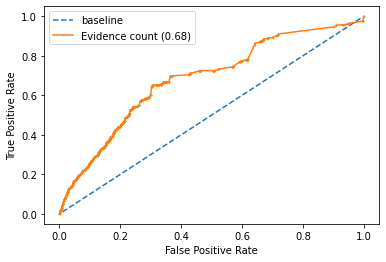

In [55]:
combined_scores = simplified_evid.groupby(['disease','target']).evidence_score.agg(harmonic_sum)
combined_scores.name = 'combined_scores'

# Grouping eva dataframe to get disease/target positive control list:
poscon = simplified_evid.groupby(['disease','target', 'poscon']).poscon.agg(any).droplevel(2)
poscon.name = 'positive_control'

# Merge two lists together:
combined_scores_df = pd.concat([combined_scores,poscon], axis=1)
combined_scores.head()

auc_varcnt = roc_auc_score(combined_scores_df.positive_control, combined_scores_df.combined_scores)
fpr_varcnt, tpr_varcnt, thresholds = roc_curve(combined_scores_df.positive_control, combined_scores_df.combined_scores)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_varcnt, tpr_varcnt, marker='.', markersize = 1, label=f'Evidence count ({auc_varcnt:.2})') # variant count

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()


In [59]:
len(combined_scores_df.loc[combined_scores_df.positive_control==1])

557

In [62]:
df = pd.DataFrame({
    'target':['t1','t2','t3','t4'],
    'disease':['d1','d2','d3','d4'],
    'phenotypes':['p1','p2;p3','p1;p3;p4','p4;p5']
})

In [65]:
(
    df
    .assign(phenotype_list = df.phenotypes.str.split(';'))
    .explode('phenotype_list')
)



,target,disease,phenotypes,phenotype_list
0,t1,d1,p1,p1
1,t2,d2,p2;p3,p2
1,t2,d2,p2;p3,p3
2,t3,d3,p1;p3;p4,p1
2,t3,d3,p1;p3;p4,p3
2,t3,d3,p1;p3;p4,p4
3,t4,d4,p4;p5,p4
3,t4,d4,p4;p5,p5
